In [1]:
import numpy as np
from glob import glob 
import os,sys
import pr2_utils
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots, figure
from tqdm import tqdm
import pickle
import cv2
import yaml
import time
%matplotlib inline

In [2]:
sb = 475.143600050775 / 1000 
#Baseline ( should we convert to mm or not ?? )

In [3]:
robot_T_Lidar = np.asarray([[0.00130201, 0.796097, 0.605167, 0.8349], \
    [0.999999, -0.000419027, -0.00160026, -0.0126869],\
    [-0.00102038, 0.605169, -0.796097, 1.76416], \
    [0, 0, 0, 1]])

def meta_constructor(loader, node):
    value = loader.construct_mapping(node)
    return value

yaml.add_constructor(u'tag:yaml.org,2002:opencv-matrix', meta_constructor)
left_camera = open("../code/param/left_camera.yaml")
left_camera = yaml.load(left_camera, Loader = yaml.FullLoader)
right_camera = open("../code/param/right_camera.yaml")
right_camera = yaml.load(right_camera, Loader = yaml.FullLoader)

In [4]:
K = np.asarray(left_camera['projection_matrix']['data']).reshape(3,-1)

In [5]:
K

array([[775.3723555 ,   0.        , 619.47309113,   0.        ],
       [  0.        , 775.3723555 , 257.18049049,   0.        ],
       [  0.        ,   0.        ,   1.        ,   0.        ]])

In [6]:
robot_T_stereo = np.asarray([[-0.00680499, -0.0153215, 0.99985, 1.64239],[ -0.999977, 0.000334627, -0.00680066, 0.247401],\
    [-0.000230383, -0.999883, -0.0153234,  1.58411],[0, 0, 0 ,1]])

In [7]:
with open('../map_parameters.pkl', 'rb') as f: 
    X = pickle.load(f)
    MAP = X[0]
    
traj = MAP['traj']
map_image = MAP['image']

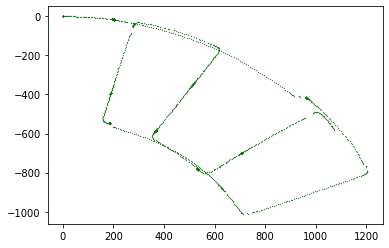

In [8]:
plt.scatter(traj[:,0], traj[:,1], c = 'g', s= 0.001)

In [9]:
stereo_left_t = []
stereo_right_t = []
folder = "../code/stereo_images/"

for file in os.listdir(folder +  'stereo_left'): 
    if file.endswith('.png'): 
        filename = file.split('.')[0]
        stereo_left_t.append(int(filename))

for file in os.listdir(folder +  'stereo_right'): 
    if file.endswith('.png'): 
        filename = file.split('.')[0]
        stereo_right_t.append(int(filename))
stereo_left_t.sort()

stereo_right_t.sort()
stereo_left_t = np.asarray(stereo_left_t).reshape(-1,1)
stereo_right_t = np.asarray_chkfinite(stereo_right_t).reshape(-1,1)
stereo_t = np.hstack((stereo_left_t, stereo_right_t))
stereo_t_diff = stereo_right_t - stereo_left_t
index = np.where(stereo_t_diff != 0)[0]
stereo_left_t = np.delete(stereo_left_t, index, axis = 0) 
stereo_right_t = np.delete(stereo_right_t, index, axis = 0) 

In [10]:
with open('../texture_mapping_variable.pkl', 'rb') as f:
    X = pickle.load(f)
d_img = X[0]
rgb_img = X[1] 
for i in range(len(rgb_img)): 
    rgb_img[i] = cv2.cvtColor(rgb_img[i], cv2.COLOR_BGR2RGB)


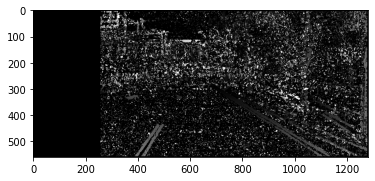

In [11]:
plt.imshow(~d_img[0], cmap = 'Greys')
plt.show(block = True)

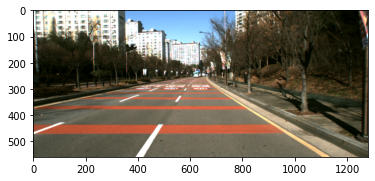

In [12]:
plt.imshow(rgb_img[0])

In [13]:
rgb_img[2][300:400, 500:600,:]

array([[[137, 127, 108],
        [139, 130, 110],
        [137, 128, 111],
        ...,
        [159, 148, 135],
        [157, 148, 135],
        [156, 149, 133]],

       [[137, 123, 108],
        [136, 127, 109],
        [134, 130, 110],
        ...,
        [159, 146, 131],
        [158, 148, 129],
        [157, 147, 128]],

       [[154, 123, 107],
        [154, 125, 108],
        [152, 123, 109],
        ...,
        [176, 146, 128],
        [174, 142, 123],
        [173, 146, 124]],

       ...,

       [[217,  99,  68],
        [216,  98,  67],
        [215,  96,  66],
        ...,
        [222, 100,  69],
        [221,  99,  70],
        [219,  99,  68]],

       [[219,  99,  69],
        [221,  99,  66],
        [216,  98,  63],
        ...,
        [220,  99,  67],
        [218,  99,  65],
        [217, 100,  65]],

       [[222,  99,  69],
        [225, 100,  67],
        [216,  98,  65],
        ...,
        [217,  99,  68],
        [216,  98,  67],
        [214, 101,  67]]

In [14]:
rgb_img[2][300:400, 500:600,:].shape

(100, 100, 3)

In [15]:
lidar_time, lidar_data = pr2_utils.read_data_from_csv('../code/sensor_data/lidar.csv')
encoder_time, encoder_data = pr2_utils.read_data_from_csv('../code/sensor_data/encoder.csv')
fog_time, fog_data = pr2_utils.read_data_from_csv('../code/sensor_data/fog.csv')
lidar_time, fog_time, encoder_time = lidar_time * (10**(-9)), fog_time * (10**(-9)), encoder_time*(10**(-9))

In [16]:
texture_map =  np.zeros((MAP['sizex'],MAP['sizey'],3)).astype(np.int16)
print(f"camera intrinsic matrix : {K}")

camera intrinsic matrix : [[775.3723555    0.         619.47309113   0.        ]
 [  0.         775.3723555  257.18049049   0.        ]
 [  0.           0.           1.           0.        ]]


Equation : $$[u,v,1] = K * \frac{1}{Zo} [Xo, Yo, Zo, 1]$$

In [17]:
for i in tqdm(range(200)):
#     d_img[i][d_img[i] > 20] = 20
    disp = np.zeros((560,1280))
    disp = cv2.normalize(d_img[1], disp,  alpha=0, beta=255,norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    z = (K[0][0] * sb)/disp
    z[z > 20] = 20
    depth = z.reshape(1,-1)
    uv = np.indices((560,1280))
    uv = uv.reshape((2,-1))
    grid_uv = np.vstack((uv[1], uv[0]))
    grid = np.vstack((grid_uv, np.ones((1, 560*1280))))
    
    xyz_o = depth * (np.linalg.inv(K[0:3 , 0:3]) @ grid) #Xo, Yo, Zo i.e. optical frame coordinates 
    xyz_o = np.vstack((xyz_o, np.ones((1, xyz_o.shape[-1]))))  #Homogenise by adding row of ones
    xyz_robot = robot_T_stereo @ xyz_o #Convert from optical frame to regular frame and regular frame camera to robot frame
    
    #Image coordinates in robot frame. Need to convert to world frame using the transformation of robot to world
    #Now time comes into play. Each stereo has a time, find corresponding encoder time and get pose of robot
    
    encoder_t = np.abs(int(stereo_left_t[i])*10**(-9) - encoder_time).argmin()
    robot_pose = MAP['traj'][encoder_t]
    
    sx,sy,theta = robot_pose[0], robot_pose[1], robot_pose[2]
    
    world_T_robot = np.asarray([[np.cos(theta),-np.sin(theta), 0, sx], \
                                [np.sin(theta) , np.cos(theta) , 0 , sy], \
                                [0, 0, 1, 0], [0,0,0,1]])
    
    #Get coordinates in world frame 
    xyz_world = world_T_robot @ xyz_robot #4 * (560*1280) matrix, x,y,z of each of the pixel
#     print(f"world points : {xyz_world}")
    ground = np.logical_and((xyz_world[2] > -0.1),(xyz_world[2] < 0.8))
    xyz_world = xyz_world[:,ground] #select only the points that are near to the road
    
    xyz_o = xyz_o[:,ground]
    uv_permissible = np.around(np.divide(K @ xyz_o, xyz_o[2])[:2]).astype(np.int16)
    x_ground= np.ceil((xyz_world[0,:] - MAP['xmin'])/MAP['res']).astype(np.int16) - 1
    y_ground= np.ceil((xyz_world[1,:] - MAP['ymin'])/MAP['res']).astype(np.int16) - 1
    texture_map[x_ground, y_ground, :] = rgb_img[i][uv_permissible[1], uv_permissible[0], :]
    

  0%|          | 0/200 [00:00<?, ?it/s]/home/sambaran/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
100%|██████████| 200/200 [00:07<00:00, 27.53it/s]


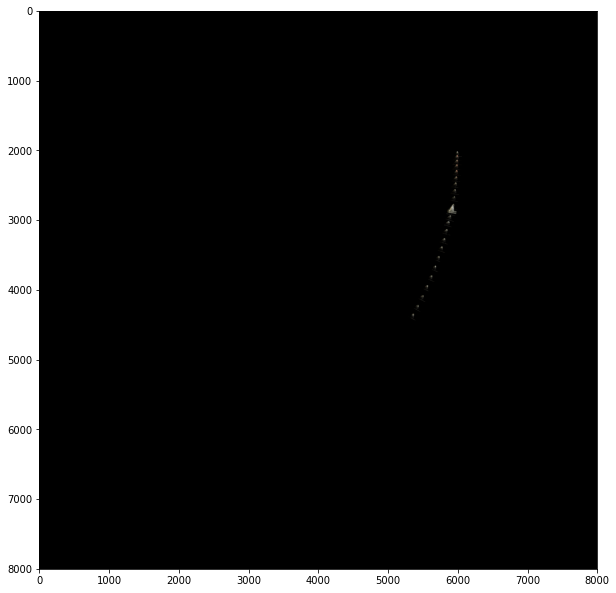

In [36]:
fig = plt.figure(figsize = (10,20))
plt.imshow(texture_map)

In [19]:
print(d_img[1])

[[-16 -16 -16 ... -16 -16 -16]
 [-16 -16 -16 ... -16 -16 -16]
 [-16 -16 -16 ... -16 -16 -16]
 ...
 [-16 -16 -16 ... -16 -16 -16]
 [-16 -16 -16 ... -16 -16 -16]
 [-16 -16 -16 ... -16 -16 -16]]


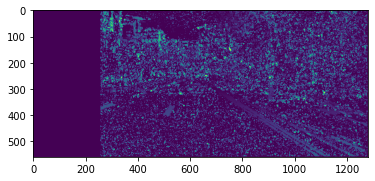

In [20]:
plt.imshow(d_img[1]/16)

In [21]:
np.linalg.norm(d_img[1])

759347.0349925652

In [22]:
disp = np.zeros((560,1280))
disp = cv2.normalize(d_img[1], disp,  alpha=0, beta=255, \
    norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

In [23]:
disp

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [24]:
np.where(disp !=0)

(array([  3,   3,   3, ..., 556, 556, 556]),
 array([ 262,  263,  271, ..., 1256, 1270, 1271]))

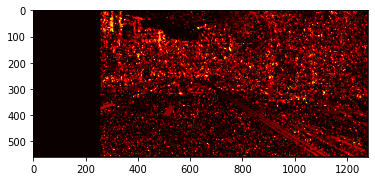

In [25]:
plt.imshow(disp, cmap = 'hot')

In [26]:
np.max(disp)

255

In [27]:
disp[500:550, 600:800]

array([[  0,   0,   0, ...,   0,   0,   0],
       [ 11,   0,   0, ...,   0,   0,   0],
       [ 11,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0, 109, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

In [28]:
Z = (K[0][0] * sb) / disp

/home/sambaran/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


In [29]:
Z[Z > 50] = 50

In [30]:
Z

array([[50., 50., 50., ..., 50., 50., 50.],
       [50., 50., 50., ..., 50., 50., 50.],
       [50., 50., 50., ..., 50., 50., 50.],
       ...,
       [50., 50., 50., ..., 50., 50., 50.],
       [50., 50., 50., ..., 50., 50., 50.],
       [50., 50., 50., ..., 50., 50., 50.]])

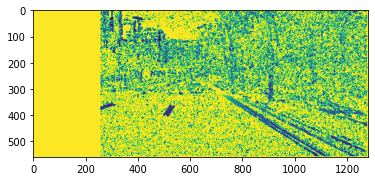

In [31]:
plt.imshow(Z)

In [32]:
Z[500:550, 600:650]

array([[50.        , 50.        , 50.        , ..., 50.        ,
        50.        ,  3.26029391],
       [33.49211022, 50.        , 50.        , ...,  2.54078077,
        50.        , 50.        ],
       [33.49211022, 50.        , 50.        , ..., 50.        ,
        50.        , 50.        ],
       ...,
       [50.        , 50.        , 50.        , ..., 50.        ,
        50.        , 50.        ],
       [50.        , 50.        ,  3.37993773, ..., 50.        ,
        50.        , 50.        ],
       [50.        , 50.        , 50.        , ..., 50.        ,
         2.17995984,  2.17995984]])

In [33]:
MAP['res']

0.25